In [4]:



!pip install git+https://github.com/huggingface/transformers
!pip install qwen-omni-utils -U
!pip install -U bitsandbytes`
import os
import soundfile as sf
import torch
import numpy as np
import librosa
import csv # Nuovo import per la gestione dei file CSV
import transformers
from transformers import Qwen2AudioForConditionalGeneration, AutoProcessor
# --- ABILITA IL DEBUGGING CUDA SYNCHRONOUS E L'ALLOCATORE DI MEMORIA ESPANDIBILE ---
# Questa configurazione aiuta a prevenire errori di memoria frammentata sulla GPU.
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# --- DEBUG GPU DISPONIBILE ---
if torch.cuda.is_available():
    # Stampa le informazioni su tutte le GPU disponibili rilevate da PyTorch.
    # Questo aiuta a capire quante risorse hardware sono a disposizione.
    for i in range(torch.cuda.device_count()):
        print(f"*** CONFERMA GPU: PyTorch rileva la GPU {i}! Nome: {torch.cuda.get_device_name(i)}, Memoria Totale: {torch.cuda.get_device_properties(i).total_memory / (1024**3):.2f} GiB")
else:
    # Avviso se nessuna GPU è disponibile, il che implica un'esecuzione molto più lenta su CPU.
    print("*** ATTENZIONE: PyTorch NON rileva la GPU. Il modello verrà caricato su CPU (potrebbe fallire per memoria).")

# --- 1. CONFIGURAZIONE GENERALE E CARICAMENTO MODELLO/PROCESSORE ---
print("Caricamento del modello Qwen2-Audio-7B-Instruct...")
# Inizializza l'AutoProcessor per il modello Qwen2-Audio-7B-Instruct.
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-Audio-7B-Instruct")

# Carica il modello Qwen2AudioForConditionalGeneration.
# device_map="auto" tenta di distribuire il modello automaticamente sulle GPU disponibili.
# torch_dtype=torch.float16 carica il modello in precisione FP16 per ridurre il consumo di VRAM,
# cruciale per modelli di grandi dimensioni su GPU con memoria limitata.
model = Qwen2AudioForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-Audio-7B-Instruct",
    device_map="auto",
    torch_dtype=torch.float16
)
print("Modello e processore Qwen2-Audio caricati con successo.")

# Svuota la cache CUDA immediatamente dopo il caricamento del modello.
# Questo è un passo cruciale per liberare qualsiasi memoria temporanea allocata durante il caricamento,
# assicurando la massima VRAM disponibile per l'inferenza.
torch.cuda.empty_cache()
print("Cache CUDA svuotata dopo il caricamento del modello.")


# --- FUNZIONE PER L'INFERENZA SU UN SINGOLO FRAMMENTO AUDIO ---
def run_audio_inference_on_segment(audio_segment: np.ndarray, user_prompt: str, model, processor, segment_samplerate: int, max_new_tokens: int = 150) -> str:
    """
    Esegue l'inferenza di Qwen2-Audio su un singolo segmento audio (array numpy) con un dato prompt.

    Args:
        audio_segment (np.ndarray): L'array numpy del segmento audio.
        user_prompt (str): Il prompt testuale specifico per l'utente per questo segmento.
        model: L'istanza del modello Qwen2AudioForConditionalGeneration già caricata.
        processor: L'istanza dell'AutoProcessor per Qwen2-Audio già caricata.
        segment_samplerate (int): Il sample rate del segmento audio.
        max_new_tokens (int): Numero massimo di nuovi token che il modello dovrebbe generare come risposta.

    Returns:
        str: La risposta testuale generata dal modello per il segmento.
    """
    # Stampa la lunghezza del segmento audio in secondi per monitoraggio.
    print(f"\n--- Inizio inferenza su segmento audio (lunghezza: {len(audio_segment)/segment_samplerate:.2f}s) ---")

    # Qwen2-Audio si aspetta un sample rate specifico (generalmente 16000 Hz).
    # Questa sezione ricasella l'audio se il sample rate originale non corrisponde,
    # garantendo la compatibilità con il modello.
    target_sr = 16000
    if segment_samplerate != target_sr:
        print(f"Ricasellamento del segmento audio da {segment_samplerate}Hz a {target_sr}Hz.")
        audio_for_processor = librosa.resample(y=audio_segment, orig_sr=segment_samplerate, target_sr=target_sr)
    else:
        audio_for_processor = audio_segment
    final_samplerate = target_sr # Il sample rate effettivo dopo il ricasellamento.

    # --- Costruzione della conversazione per il modello ---
    # Il prompt di sistema definisce il ruolo del modello e il formato di output desiderato.
    # Non include più la richiesta di valori numerici per le emozioni.
    system_prompt = """Sei un analista musicale altamente specializzato e descrittivo.
Il tuo compito è analizzare il frammento audio fornito e fornire una descrizione concisa ma ricca di dettagli, coprendo gli aspetti richiesti.
La tua risposta deve essere in italiano.
Devi includere:
1.  **Descrizione Dettagliata:** Strumenti, velocità/ritmo, timbro, emozioni suscitate, e un contesto immaginato. (max 4-6 righe)
"""

    conversation = [
        {
            "role": "system",
            "content": system_prompt
        },
        {
            "role": "user",
            "content": [
                {"type": "audio", "audio": audio_for_processor}, # Passa l'array NumPy dell'audio.
                {"type": "text", "text": user_prompt}, # user_prompt è ora il prompt specifico per il frammento.
            ],
        },
    ]

    print("Preparazione degli input per il modello Qwen2-Audio...")
    # Applica il template di chat e tokenizza il testo e l'audio.
    # `padding=True` assicura che tutti gli input siano della stessa lunghezza per il batch processing.
    text_input_formatted = processor.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False)
    
    # La lista degli array audio è necessaria per il processore.
    audios_np_arrays = [audio_for_processor]

    inputs = processor(text=text_input_formatted, audios=audios_np_arrays, sampling_rate=final_samplerate, return_tensors="pt", padding=True)

    # Sposta i tensori di input sul dispositivo del modello (GPU o CPU).
    inputs.input_ids = inputs.input_ids.to(model.device)
    if "input_features" in inputs:
        inputs["input_features"] = inputs["input_features"].to(model.device)
    # Alcuni modelli potrebbero usare 'pixel_values' per le feature audio/multimodali.
    elif "pixel_values" in inputs:
        inputs["pixel_values"] = inputs["pixel_values"].to(model.device)
    else:
        print("Avviso: Nessun 'input_features' o 'pixel_values' trovato negli input. Controlla la documentazione del modello.")

    # Stampa la lunghezza dei token di input per debugging.
    print(f"Lunghezza degli input_ids dopo tokenizzazione: {inputs.input_ids.size(1)}")
    print("Input pronti per la generazione.")

    # Svuota la cache CUDA prima della generazione per massimizzare la memoria disponibile.
    # Questo è fondamentale per prevenire OutOfMemoryError tra le chiamate di inferenza.
    torch.cuda.empty_cache()

    print("Generazione della risposta del modello... Potrebbe richiedere tempo.")
    # Genera la risposta testuale dal modello.
    # `max_new_tokens` controlla la lunghezza massima dell'output generato.
    generate_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)

    # Estrai solo i token generati dal modello (escludendo i token di input).
    generated_ids_only = generate_ids[:, inputs.input_ids.size(1):]
    # Decodifica i token generati in testo leggibile.
    response_text = processor.batch_decode(generated_ids_only, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

    print("\n--- TESTO GENERATO DAL MODELLO ---\n")
    print(response_text)
    print(f"--- Fine inferenza su segmento audio ---\n")

    return response_text

# --- SEZIONE PRINCIPALE: SUDDIVISIONE E ANALISI DI PIÙ AUDIO DA UNA CARTELLA ---

# Imposta il percorso della cartella che contiene i tuoi file audio.
# ASSICURATI CHE QUESTO PERCORSO SIA CORRETTO PER IL TUO AMBIENTE KAGGLE/COLAB.
audio_directory_path = "/kaggle/input/le-musiche/PiccoloSubSetAudio/"

# Verifica che la cartella esista.
if not os.path.exists(audio_directory_path):
    raise FileNotFoundError(f"La cartella audio non trovata: {audio_directory_path}. Assicurati di aver caricato la cartella come Dataset e di aver specificato il percorso corretto.")

# Nome del file CSV in cui verranno salvati i risultati.
csv_output_filename = "analisi_audio_per_canzone.csv"

# Apertura del file CSV in modalità scrittura.
# 'newline=''' evita righe vuote extra.
# 'encoding='utf-8''' per supportare caratteri speciali.
with open(csv_output_filename, 'w', newline='', encoding='utf-8') as csvfile:
    # Definisce le intestazioni delle colonne del CSV.
    fieldnames = ['Nome Canzone']
    for i in range(1, 6): # Per 5 frammenti: 'Descr Frammento 1', 'Descr Frammento 2', ...
        fieldnames.append(f'Descr Frammento {i}')
    fieldnames.append('Descrizione Totale') # Aggiunge la colonna per la descrizione complessiva.
    
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader() # Scrive la riga di intestazione nel CSV.

    print(f"\nI risultati dell'analisi verranno salvati in: {csv_output_filename}")

    # Impostazione fissa del numero di frammenti per ogni audio.
    N_FIXED_SEGMENTS = 5 # Vogliamo esattamente 5 frammenti per ogni file audio.

    # Itera su tutti i file presenti nella cartella specificata.
    for filename in os.listdir(audio_directory_path):
        # Filtra solo i file audio con estensione .mp3 o .wav (case-insensitive).
        if filename.lower().endswith((".mp3", ".wav")):
            audio_file_path = os.path.join(audio_directory_path, filename)
            print(f"\n\n--- INIZIO ELABORAZIONE FILE: {filename} ---")

            # Carica l'intero audio dal file.
            # librosa.load è robusto per vari formati e può rilevare il sample rate.
            print(f"Caricamento dell'intero audio: {audio_file_path}")
            full_audio_data, full_samplerate = librosa.load(audio_file_path, sr=None)
            audio_duration = len(full_audio_data) / full_samplerate
            print(f"L'audio completo è lungo: {audio_duration:.2f} secondi.")

            # Calcola la durata di ogni frammento per ottenere esattamente N_FIXED_SEGMENTS.
            print(f"Dividendo l'audio in esattamente {N_FIXED_SEGMENTS} frammenti di durata fissa.")
            
            # Calcola la durata media di ogni frammento.
            segment_duration_seconds = audio_duration / N_FIXED_SEGMENTS
            # Converti la durata in numero di campioni.
            samples_per_segment = int(segment_duration_seconds * full_samplerate)

            song_descriptions = {} # Dizionario per archiviare le descrizioni dei 5 frammenti per la canzone corrente.
            full_song_description_parts = [] # Lista per costruire la descrizione totale della canzone.

            # Il prompt base per l'utente, che verrà combinato con le istruzioni del sistema.
            base_user_instruction = """Descrivi in 4-6 righe il frammento della canzone fornita, includendo i seguenti aspetti:
1.  **Strumenti presenti**
2.  **Velocità/ritmo**
3.  **Timbro**
4.  **Emozioni suscitate**
5.  **Contesto immaginato**
Cerca di essere il più descrittivo possibile pur mantenendo la lunghezza entro il limite.
"""

            # Loop per processare ogni frammento dell'audio.
            for i in range(N_FIXED_SEGMENTS):
                # Calcola i campioni di inizio e fine per il frammento corrente.
                start_sample = i * samples_per_segment
                # L'ultimo frammento si estende fino alla fine dell'audio per coprire eventuali resti.
                end_sample = min((i + 1) * samples_per_segment, len(full_audio_data))
                
                # Estrai il segmento di audio corrente.
                current_segment = full_audio_data[start_sample:end_sample]

                # Prepara il prompt specifico per questo frammento, indicando il suo numero.
                segment_prompt = f"Analizza il frammento {i+1}/{N_FIXED_SEGMENTS} dell'audio. {base_user_instruction}"
                
                # Esegui l'inferenza sul segmento audio corrente.
                response_text = run_audio_inference_on_segment(
                    audio_segment=current_segment,
                    user_prompt=segment_prompt,
                    model=model,
                    processor=processor,
                    segment_samplerate=full_samplerate,
                    max_new_tokens=150 # Numero massimo di token da generare per la risposta di ogni segmento.
                )
                
                # Archivia la descrizione del frammento con la chiave appropriata per il CSV.
                song_descriptions[f'Descr Frammento {i+1}'] = response_text
                # Aggiungi la descrizione del frammento alla lista per la descrizione totale.
                full_song_description_parts.append(f"Frammento {i+1}: {response_text.strip()}")
                
                # Svuota esplicitamente la cache GPU dopo ogni elaborazione di frammento.
                # Questo è cruciale per la gestione della memoria in un ciclo intensivo.
                torch.cuda.empty_cache()
                print(f"Cache CUDA svuotata dopo l'analisi del frammento {i+1} per {filename}.")
            
            # --- Scrittura della riga completa per la canzone nel CSV ---
            csv_row = {'Nome Canzone': filename}
            csv_row.update(song_descriptions) # Aggiunge le descrizioni dei 5 frammenti al dizionario della riga.
            # Concatena tutte le descrizioni dei frammenti per la "Descrizione Totale", separate da due nuove linee.
            csv_row['Descrizione Totale'] = "\n\n".join(full_song_description_parts)

            writer.writerow(csv_row) # Scrive la riga completa della canzone nel file CSV.

            print(f"--- FINE ELABORAZIONE FILE: {filename} ---\n")
            
            # Una pulizia aggiuntiva della cache GPU dopo aver processato un intero file.
            torch.cuda.empty_cache()
            print(f"Cache CUDA svuotata dopo l'elaborazione completa di {filename}.")

# Messaggio finale che indica il completamento del processo e il nome del file CSV.
print(f"\nProcesso di analisi audio per tutti i file della cartella completato. Risultati salvati in '{csv_output_filename}'.")


  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-vrlshifk
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-vrlshifk
  Resolved https://github.com/huggingface/transformers to commit d7b87b415a5dd4a3152051e1a0abd098a02c5bfa
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
/bin/bash: -c: line 1: unexpected EOF while looking for matching ``'
/bin/bash: -c: line 2: syntax error: unexpected end of file


2025-06-09 13:18:08.770514: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749475088.980137      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749475089.047196      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


*** CONFERMA GPU: PyTorch rileva la GPU 0! Nome: Tesla T4, Memoria Totale: 14.74 GiB
*** CONFERMA GPU: PyTorch rileva la GPU 1! Nome: Tesla T4, Memoria Totale: 14.74 GiB
Caricamento del modello Qwen2-Audio-7B-Instruct...


preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/638k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/853 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/79.0k [00:00<?, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.28G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.91G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

Modello e processore Qwen2-Audio caricati con successo.
Cache CUDA svuotata dopo il caricamento del modello.

I risultati dell'analisi verranno salvati in: analisi_audio_per_canzone.csv


--- INIZIO ELABORAZIONE FILE: 000207.mp3 ---
Caricamento dell'intero audio: /kaggle/input/le-musiche/PiccoloSubSetAudio/000207.mp3
L'audio completo è lungo: 29.98 secondi.
Dividendo l'audio in esattamente 5 frammenti di durata fissa.

--- Inizio inferenza su segmento audio (lunghezza: 6.00s) ---
Ricasellamento del segmento audio da 44100Hz a 16000Hz.
Preparazione degli input per il modello Qwen2-Audio...
Lunghezza degli input_ids dopo tokenizzazione: 408
Input pronti per la generazione.
Generazione della risposta del modello... Potrebbe richiedere tempo.


/tmp/ipykernel_35/3093647263.py:112: FutureWarning: `audios` is deprecated and will be removed in version 4.54.0 for `Qwen2AudioProcessor.__call__`. Use `audio` instead.
  inputs = processor(text=text_input_formatted, audios=audios_np_arrays, sampling_rate=final_samplerate, return_tensors="pt", padding=True)
/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:2495: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(



--- TESTO GENERATO DAL MODELLO ---

Nel primo minuto e mezzo della canzone si sentono due pianoforti che suonano in modo dissonante, creando un senso di confusione e incertezza. La velocità del brano è media, con un ritmo costante che non cambia durante l'intera durata. Il tono degli strumenti è cupo e malinconico, evocando sensazioni di tristezza e solitudine. Immagino una scena di un film drammatico o di un musical in cui i personaggi principali sono in un momento di profonda crisi emotiva.
--- Fine inferenza su segmento audio ---

Cache CUDA svuotata dopo l'analisi del frammento 1 per 000207.mp3.

--- Inizio inferenza su segmento audio (lunghezza: 6.00s) ---
Ricasellamento del segmento audio da 44100Hz a 16000Hz.
Preparazione degli input per il modello Qwen2-Audio...
Lunghezza degli input_ids dopo tokenizzazione: 408
Input pronti per la generazione.
Generazione della risposta del modello... Potrebbe richiedere tempo.

--- TESTO GENERATO DAL MODELLO ---

Nel secondo segmento della c

In [1]:


!pip install git+https://github.com/huggingface/transformers
!pip install qwen-omni-utils -U
!pip install -U bitsandbytes`
import os
import soundfile as sf
import torch
import numpy as np
import librosa
# Non abbiamo più bisogno di tempfile per Qwen2-Audio (accetta np array)
# Non abbiamo più bisogno di gc per Qwen2-Audio (meno VRAM esigente)
from transformers import Qwen2AudioForConditionalGeneration, AutoProcessor
# Rimosso from sklearn.cluster import KMeans

# --- ABILITA IL DEBUGGING CUDA SYNCHRONOUS E L'ALLOCATORE DI MEMORIA ESPANDIBILE ---
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# --- DEBUG GPU DISPONIBILE ---
if torch.cuda.is_available():
    # Stampa le informazioni su tutte le GPU disponibili
    for i in range(torch.cuda.device_count()):
        print(f"*** CONFERMA GPU: PyTorch rileva la GPU {i}! Nome: {torch.cuda.get_device_name(i)}, Memoria Totale: {torch.cuda.get_device_properties(i).total_memory / (1024**3):.2f} GiB")
else:
    print("*** ATTENZIONE: PyTorch NON rileva la GPU. Il modello verrà caricato su CPU (potrebbe fallire per memoria).")

# --- 1. CONFIGURAZIONE GENERALE E CARICAMENTO MODELLO/PROCESSORE ---
print("Caricamento del modello Qwen2-Audio-7B-Instruct...")
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-Audio-7B-Instruct")
model = Qwen2AudioForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-Audio-7B-Instruct",
    device_map="auto", # Mantiene la distribuzione automatica su più GPU se necessario
    torch_dtype=torch.float16 # Carica il modello in FP16 (riduce VRAM della metà rispetto a FP32)
)
print("Modello e processore Qwen2-Audio caricati con successo.")

# Svuota la cache dopo il caricamento del modello. Questo è molto importante.
torch.cuda.empty_cache()
print("Cache CUDA svuotata dopo il caricamento del modello.")


# --- FUNZIONE PER L'INFERENZA SU UN SINGOLO FRAMMENTO AUDIO ---
def run_audio_inference_on_segment(audio_segment, user_prompt, model, processor, segment_samplerate, max_new_tokens=150):
    """
    Esegue l'inferenza di Qwen2-Audio su un singolo segmento audio (array numpy) con un dato prompt.

    Args:
        audio_segment (np.ndarray): L'array numpy del segmento audio.
        user_prompt (str): Il prompt testuale per il modello.
        model: L'istanza del modello Qwen2AudioForConditionalGeneration.
        processor: L'istanza dell'AutoProcessor per Qwen2-Audio.
        segment_samplerate (int): Il sample rate del segmento audio.
        max_new_tokens (int): Numero massimo di nuovi token da generare.

    Returns:
        str: La risposta testuale generata dal modello.
    """
    print(f"\n--- Inizio inferenza su segmento audio (lunghezza: {len(audio_segment)/segment_samplerate:.2f}s) ---")

    # Ricasellamento del segmento audio al sample rate richiesto dal modello Qwen2-Audio
    target_sr = 16000 # Il sample rate predefinito per Qwen2-Audio
    if segment_samplerate != target_sr:
        print(f"Ricasellamento del segmento audio da {segment_samplerate}Hz a {target_sr}Hz.")
        audio_for_processor = librosa.resample(audio_segment, orig_sr=segment_samplerate, target_sr=target_sr)
    else:
        audio_for_processor = audio_segment
    final_samplerate = target_sr

    # Costruzione della conversazione per il modello
    conversation = [
        {
            "role": "system",
            "content": "Sei un analista musicale altamente specializzato e descrittivo. Il tuo compito è analizzare un frammento audio e fornire una descrizione concisa ma ricca di dettagli. La tua risposta deve essere in italiano e contenere i seguenti aspetti: strumenti, velocità, timbro, emozioni suscitate, un contesto immaginato, e dei valori numerici da 0 (nullo) a 255 (alto) per 'calma', 'tristezza' e 'agitazione'."
        },
        {
            "role": "user",
            "content": [
                {"type": "audio", "audio": audio_for_processor},
                {"type": "text", "text": f"""{user_prompt}

Assegna anche dei valori numerici da 0 (nullo) a 255 (alto) per quanto il frammento ispira calma, tristezza e agitazione.

**Esempi:**
- Halleluia: Agitazione 0, Calma 255, Tristezza 150
- We Will Rock You: Agitazione 255, Calma 0, Tristezza 0
"""},
            ],
        },
    ]

    print("Preparazione degli input per il modello Qwen2-Audio...")
    text_input_formatted = processor.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False)

    audios_np_arrays = [audio_for_processor]

    inputs = processor(text=text_input_formatted, audios=audios_np_arrays, sampling_rate=final_samplerate, return_tensors="pt", padding=True)

    inputs.input_ids = inputs.input_ids.to(model.device)
    if "input_features" in inputs:
        inputs["input_features"] = inputs["input_features"].to(model.device)
    elif "pixel_values" in inputs:
        inputs["pixel_values"] = inputs["pixel_values"].to(model.device)
    else:
        print("Avviso: Nessun 'input_features' o 'pixel_values' trovato negli input. Controlla la documentazione del modello.")

    print(f"Lunghezza degli input_ids dopo tokenizzazione: {inputs.input_ids.size(1)}")
    print("Input pronti per la generazione.")

    # Svuota la cache prima della generazione per massimizzare la memoria disponibile
    torch.cuda.empty_cache()

    print("Generazione della risposta del modello... Potrebbe richiedere tempo.")
    generate_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)

    generated_ids_only = generate_ids[:, inputs.input_ids.size(1):]
    response = processor.batch_decode(generated_ids_only, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

    print("\n--- TESTO GENERATO DAL MODELLO ---\n")
    print(response)
    print(f"--- Fine inferenza su segmento audio ---\n")

    return response

# --- SEZIONE PRINCIPALE: SUDDIVISIONE E ANALISI ---

# Percorso del tuo file audio
audio_file_path = "/kaggle/input/le-musiche/PiccoloSubSetAudio/000141.mp3" # Assicurati che il percorso sia corretto

if not os.path.exists(audio_file_path):
    raise FileNotFoundError(f"Il file audio non trovato: {audio_file_path}. Assicurati di aver caricato l'audio come Dataset e di aver specificato il percorso corretto.")

# Carica l'intero audio
print(f"Caricamento dell'intero audio: {audio_file_path}")
full_audio_data, full_samplerate = librosa.load(audio_file_path, sr=None)
audio_duration = len(full_audio_data) / full_samplerate
print(f"L'audio completo è lungo: {audio_duration:.2f} secondi.")

# --- IMPOSTAZIONE ESPLICITA DEL NUMERO DI FRAMMENTI ---
N_SEGMENTS_FIXED = 5 # Vogliamo esattamente 5 frammenti

print(f"Dividendo l'audio in esattamente {N_SEGMENTS_FIXED} frammenti di durata fissa.")

# Calcola la durata approssimativa di ogni frammento
segment_duration_seconds = audio_duration / N_SEGMENTS_FIXED
samples_per_segment = int(segment_duration_seconds * full_samplerate)

all_responses = [] # Lista per accumulare le risposte di ogni frammento

base_prompt = """Descrivi in 4-6 righe il frammento della canzone fornita, includendo i seguenti aspetti:
1.  **Strumenti presenti**
2.  **Velocità/ritmo**
3.  **Timbro**
4.  **Emozioni suscitate**
5.  **Contesto immaginato**
Cerca di essere il più descrittivo possibile pur mantenendo la lunghezza entro il limite.
"""

# Iterazione per creare esattamente N_SEGMENTS_FIXED frammenti
for i in range(N_SEGMENTS_FIXED):
    start_sample = i * samples_per_segment
    # L'ultimo frammento va fino alla fine dell'audio
    end_sample = min((i + 1) * samples_per_segment, len(full_audio_data))
    
    current_segment = full_audio_data[start_sample:end_sample]
    
    # Il prompt dell'utente ora include la richiesta dei valori numerici
    segment_prompt = f"Analizza il frammento {i+1}/{N_SEGMENTS_FIXED} dell'audio. {base_prompt}"
    
    response = run_audio_inference_on_segment(
        audio_segment=current_segment,
        user_prompt=segment_prompt,
        model=model,
        processor=processor,
        segment_samplerate=full_samplerate,
        max_new_tokens=150
    )
    all_responses.append(f"Risposta per frammento {i+1}:\n{response}\n")
    
    # Svuota esplicitamente la cache GPU dopo ogni frammento
    torch.cuda.empty_cache()
    print(f"Cache CUDA svuotata dopo l'analisi del frammento {i+1}.")

print("\n--- TUTTE LE RISPOSTE DEI FRAMMENTI ---\n")
for res in all_responses:
    print(res)

print(f"\nProcesso di analisi audio diviso in esattamente {N_SEGMENTS_FIXED} frammenti completato.")

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-v23nxii5
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-v23nxii5
  Resolved https://github.com/huggingface/transformers to commit d7b87b415a5dd4a3152051e1a0abd098a02c5bfa
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
/bin/bash: -c: line 1: unexpected EOF while looking for matching ``'
/bin/bash: -c: line 2: syntax error: unexpected end of file


2025-06-09 10:59:55.843702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749466795.871717     167 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749466795.880591     167 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


*** CONFERMA GPU: PyTorch rileva la GPU 0! Nome: Tesla T4, Memoria Totale: 14.74 GiB
*** CONFERMA GPU: PyTorch rileva la GPU 1! Nome: Tesla T4, Memoria Totale: 14.74 GiB
Caricamento del modello Qwen2-Audio-7B-Instruct...


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Modello e processore Qwen2-Audio caricati con successo.
Cache CUDA svuotata dopo il caricamento del modello.
Caricamento dell'intero audio: /kaggle/input/le-musiche/PiccoloSubSetAudio/000141.mp3
L'audio completo è lungo: 29.98 secondi.
Dividendo l'audio in esattamente 5 frammenti di durata fissa.

--- Inizio inferenza su segmento audio (lunghezza: 6.00s) ---
Ricasellamento del segmento audio da 44100Hz a 16000Hz.
Preparazione degli input per il modello Qwen2-Audio...
Lunghezza degli input_ids dopo tokenizzazione: 517
Input pronti per la generazione.
Generazione della risposta del modello... Potrebbe richiedere tempo.


/tmp/ipykernel_167/2685735904.py:95: FutureWarning: `audios` is deprecated and will be removed in version 4.54.0 for `Qwen2AudioProcessor.__call__`. Use `audio` instead.
  inputs = processor(text=text_input_formatted, audios=audios_np_arrays, sampling_rate=final_samplerate, return_tensors="pt", padding=True)
/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:2495: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(



--- TESTO GENERATO DAL MODELLO ---

Nel primo segmento della canzone, si sente l'utilizzo di diversi strumenti musicali tra cui un violino, un cello, una tromba e un pianoforte. Questi strumenti creano un senso di tensione e attesa. La velocità del brano è media, con un ritmo incalzante che aumenta l'emozione di aspettativa. Il tono generale del brano è cupo e malinconico, creando un senso di tristezza e ansia. L'immagine che si viene a formare è quella di una notte tempestosa, dove le stelle brillano nel cielo bu
--- Fine inferenza su segmento audio ---

Cache CUDA svuotata dopo l'analisi del frammento 1.

--- Inizio inferenza su segmento audio (lunghezza: 6.00s) ---
Ricasellamento del segmento audio da 44100Hz a 16000Hz.
Preparazione degli input per il modello Qwen2-Audio...
Lunghezza degli input_ids dopo tokenizzazione: 517
Input pronti per la generazione.
Generazione della risposta del modello... Potrebbe richiedere tempo.

--- TESTO GENERATO DAL MODELLO ---

Nel secondo segmento 

Sto per visualizzare i colori delle prime 5 canzoni.
Chiudi ogni finestra per procedere alla successiva.


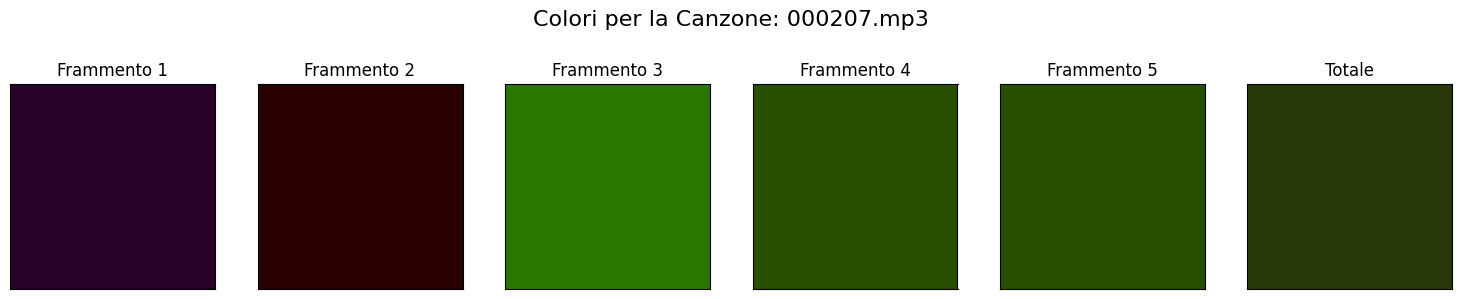

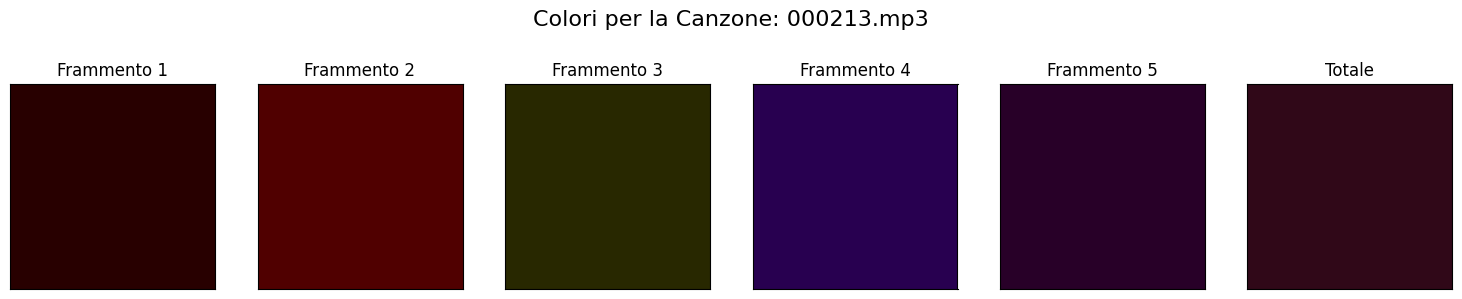

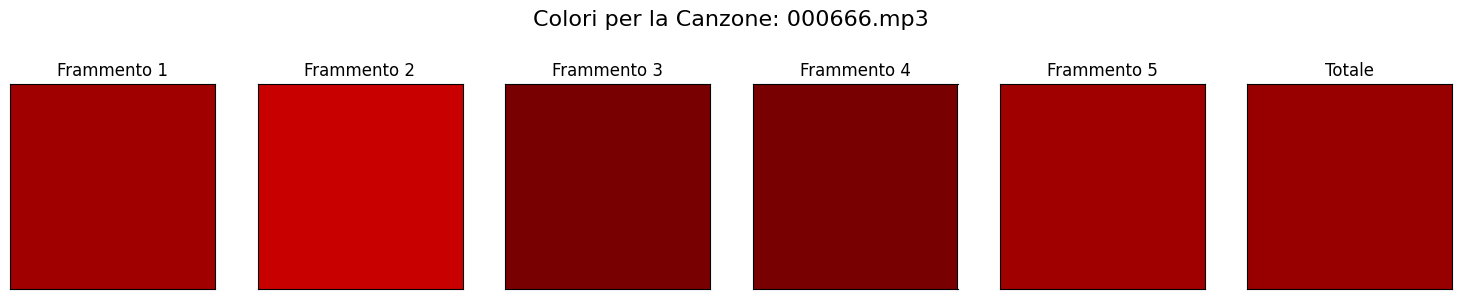

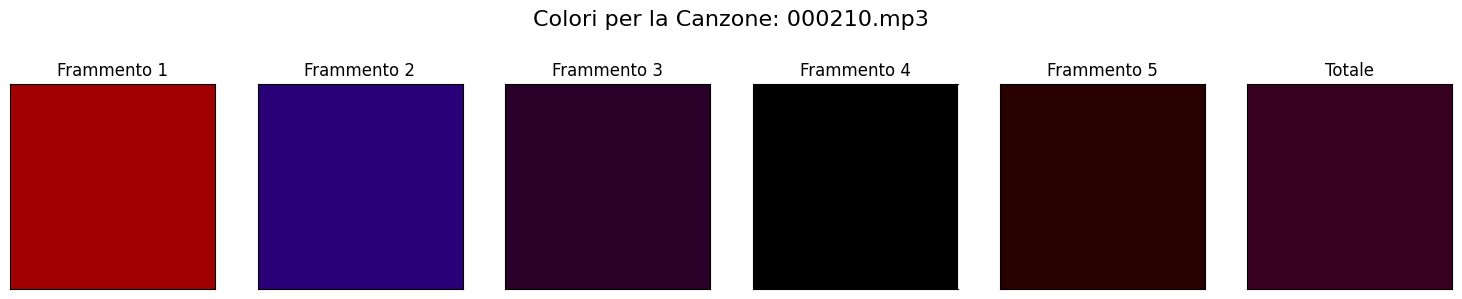

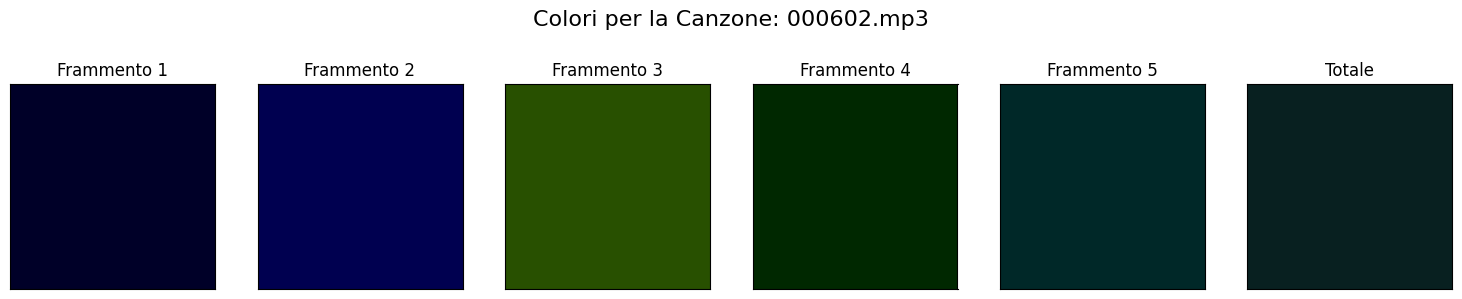


Visualizzazione completata. Modifica il parametro 'max_canzoni' per vederne di più.


In [5]:
import csv
import matplotlib.pyplot as plt
import re

def parse_rgb_to_normalized_tuple(rgb_string):
    """
    Converte una stringa come "rgb(r, g, b)" in una tupla di float (r, g, b)
    normalizzati nell'intervallo [0, 1] per matplotlib.
    """
    try:
        # Trova tutti i numeri nella stringa usando un'espressione regolare
        numeri = re.findall(r'\d+', rgb_string)
        if len(numeri) == 3:
            # Converte i numeri in interi e li normalizza dividendoli per 255.0
            r = int(numeri[0]) / 255.0
            g = int(numeri[1]) / 255.0
            b = int(numeri[2]) / 255.0
            return (r, g, b)
        else:
            # Ritorna il nero se il formato non è corretto
            return (0, 0, 0)
    except (ValueError, IndexError):
        # Ritorna il nero in caso di errore
        return (0, 0, 0)

def visualizza_colori_canzoni(nome_file_csv, max_canzoni=5):
    """
    Legge un file CSV e visualizza i colori per ogni canzone usando matplotlib.
    Mostra una finestra per ogni canzone, una alla volta.

    Args:
        nome_file_csv (str): Il nome del file CSV da leggere.
        max_canzoni (int): Il numero massimo di canzoni da visualizzare.
    """
    try:
        with open(nome_file_csv, mode='r', newline='', encoding='utf-8') as file:
            lettore_csv = csv.reader(file)
            header = next(lettore_csv) # Salta l'intestazione

            print(f"Sto per visualizzare i colori delle prime {max_canzoni} canzoni.")
            print("Chiudi ogni finestra per procedere alla successiva.")

            canzoni_visualizzate = 0
            for riga in lettore_csv:
                if not riga:
                    continue

                if canzoni_visualizzate >= max_canzoni:
                    print(f"\nVisualizzazione completata. Modifica il parametro 'max_canzoni' per vederne di più.")
                    break

                # Estrae i dati dalla riga del CSV 
                nome_canzone = riga[0]
                colori_stringa = riga[1:7] # Prende i 5 frammenti e il totale

                # Converte le stringhe in colori visualizzabili
                colori = [parse_rgb_to_normalized_tuple(s) for s in colori_stringa]
                
                # Crea la figura e i subplot (1 riga, 6 colonne)
                fig, axes = plt.subplots(1, 6, figsize=(15, 3))
                fig.suptitle(f"Colori per la Canzone: {nome_canzone}", fontsize=16)

                titoli = [f"Frammento {i+1}" for i in range(5)] + ["Totale"]

                for ax, colore, titolo in zip(axes, colori, titoli):
                    # Mostra un riquadro con il colore corrispondente
                    ax.imshow([[colore]])
                    ax.set_title(titolo)
                    # Nasconde gli assi per una visualizzazione più pulita
                    ax.set_xticks([])
                    ax.set_yticks([])

                plt.tight_layout(rect=[0, 0, 1, 0.9]) # Adegua il layout per far spazio al titolo
                plt.show() # Mostra la finestra per la canzone corrente

                canzoni_visualizzate += 1

    except FileNotFoundError:
        print(f"ERRORE: Il file '{nome_file_csv}' non è stato trovato.")
    except ImportError:
        print("ERRORE: La libreria 'matplotlib' non è installata.")
        print("Per favore, installala eseguendo il comando: pip install matplotlib")
    except Exception as e:
        print(f"Si è verificato un errore imprevisto: {e}")


# --- ESECUZIONE DELLO SCRIPT ---
file_da_leggere = '/kaggle/input/valutazione-rgb-segmenti/valutazione_rgb_segmenti.csv'

# Visualizza i colori per le prime 5 canzoni nel file.
# Puoi cambiare questo numero se vuoi vederne di più o di meno.
visualizza_colori_canzoni(file_da_leggere, max_canzoni=5)